In [1]:
import json
import csv
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

In [2]:
sf_data = pd.read_csv("san_francisco-censustracts-2017-4-All-MonthlyAggregate.csv")
sf_data = sf_data[sf_data.month == 12]

with open('san_francisco_censustracts.json') as f:
    data = json.load(f)

#key: movement id, value: street address
id_addr_dict = {}
#key: movement id, value: mean coor
id_coor_dict = {}

n = len(data['features'])
for i in range(n):
    address = data['features'][i]['properties']['DISPLAY_NAME']
    movement_id = int(data['features'][i]['properties']['MOVEMENT_ID'])
    coor_lists = np.asarray(data['features'][i]['geometry']['coordinates'][0][0])
    coor = np.asarray(coor_lists)
    
    assert coor.shape[1] == 2, "Coor dimension wrong: {}".format(i)
    
    mean_coor = np.mean(coor, axis=0)
    id_addr_dict[movement_id] = address
    id_coor_dict[movement_id] = mean_coor

In [3]:
all_ids = set(id_addr_dict.keys())
pairs_1 = [(sourceid, dstid) for sourceid in all_ids for dstid in all_ids if sourceid != dstid] 
pairs_2 = list(zip(sf_data['sourceid'], sf_data['dstid']))
# get all pairs for edgelist
all_pairs = list(set(pairs_1).intersection(pairs_2))
len(all_pairs)

538998

In [4]:
# get all id in edgelist
ids = set([element for tuple_ in all_pairs for element in tuple_])
# get keys need to delete in id_addr_dict and id_coor_dict 
to_del = [i for i in id_addr_dict.keys() if i not in ids]
for key in to_del:
    del id_coor_dict[key]
    del id_addr_dict[key]

print(len(ids))
assert len(ids) == len(id_addr_dict), "len(ids) != len(id_coor_dict)"
assert len(ids) == len(id_coor_dict), "len(ids) != len(id_coor_dict)"

1887


- **Save id_addr and id_coor dictionary to csv file**

In [5]:
with open('id_addr.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['id', 'addr'])
    for each_id in id_addr_dict:
        spamwriter.writerow([each_id, id_addr_dict[each_id]])

with open('id_coor.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['id', 'addr'])
    for each_id in id_coor_dict:
        spamwriter.writerow([each_id, id_coor_dict[each_id]])

In [6]:
with open('id_long_lat.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['id', 'long', 'lat'])
    for each_id in id_coor_dict:
        temp = 'X' + str(each_id)
        spamwriter.writerow([temp, id_coor_dict[each_id][0], id_coor_dict[each_id][1]])

- **Save edge list to csv file**

In [7]:
i = 0
with open('edge_list.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for (sourceid, dstid) in all_pairs:
        df_filt = sf_data[(sf_data['sourceid']==sourceid) & (sf_data['dstid']==dstid)]
        mean_travel_time = float(df_filt['mean_travel_time'])
        spamwriter.writerow([sourceid, dstid, mean_travel_time])
        i += 1

- **Get weight matrix from edge list and save it to csv file**

In [8]:
weight_dict = {}
for line in open("edge_list.csv"):
    items = line.split(',')
    k = str(items[0]) + '&' + str(items[1])
    weight_dict[k] = items[2]
    
matrix_ = np.zeros([len(ids), len(ids)])
i = 0
for sourceid in ids:
    j = 0
    for dstid in ids:
        k = str(sourceid) + '&' + str(dstid)
        if (j > i) and k in weight_dict.keys():
            w = weight_dict[k]
            matrix_[i][j] = w
        j += 1
    i += 1

In [9]:
df = pd.DataFrame(matrix_, index=ids, columns=ids)
df.to_csv("weight_mat.csv", index=True, header=True, sep=',')

- **Question 10:** Plot the trajectory that Santa has to travel!

In [12]:
ids = []
with open('TSP.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        vertex_id = row['x'].replace('X', '')
        ids.append(vertex_id)

In [13]:
def coor2xy(lon, lat):
    x = sin(pi/2-lat) * cos(lon)
    y = sin(pi/2-lat) * sin(lon)
    return x, y

In [14]:
longitude = []
latitude = []
coor_lonlat = []
x_ = []
y_ = []
coor_xy = []
for i in ids:
    coor = id_coor_dict[int(i)]
    coor_lonlat.append(coor)   
    latitude.append(coor[0])
    longitude.append(coor[1])
    x, y = coor2xy(coor[0], coor[1])
    x_.append(x)
    y_.append(y)
    coor_xy.append([x, y])
coor_lonlat = np.array(coor_lonlat)
coor_xy = np.array(coor_xy)

*in longitude-latitude dimension*

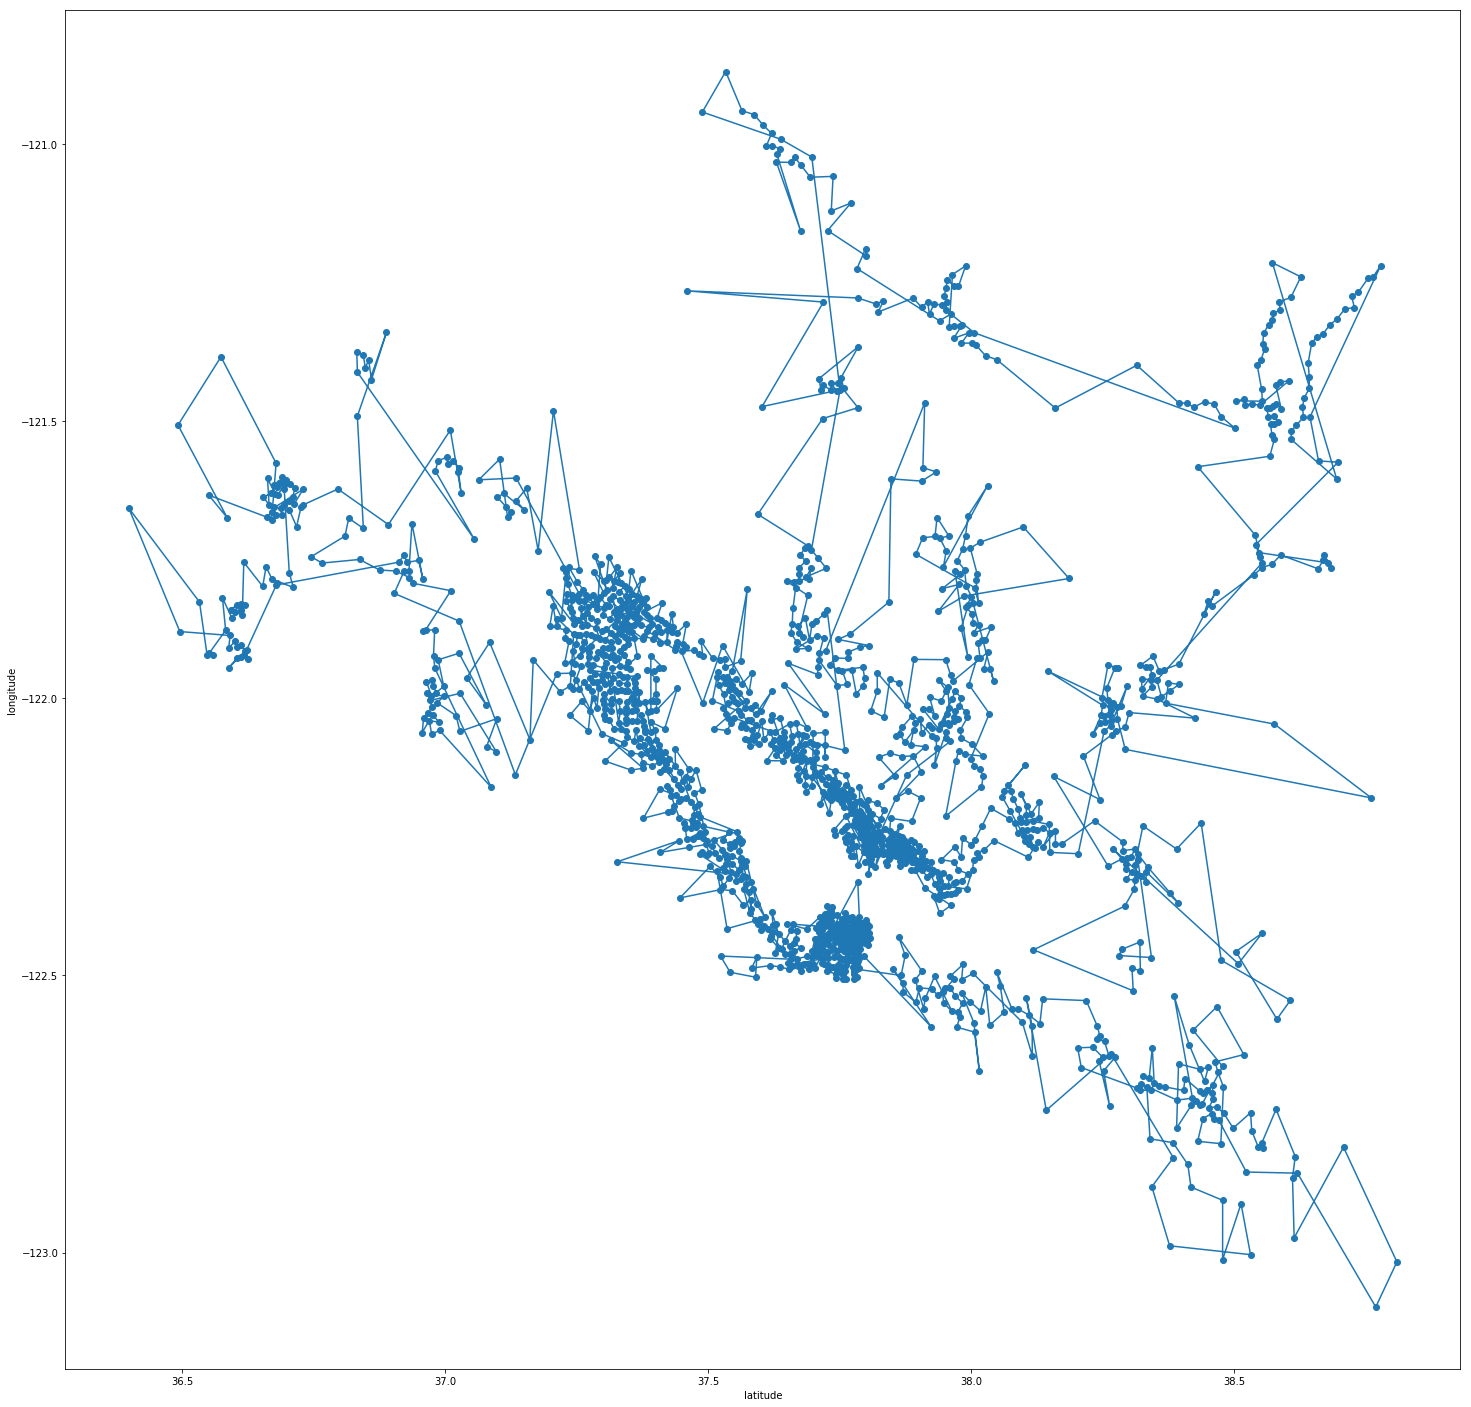

In [15]:
plt.figure(figsize=(25, 25))
plt.plot(longitude, latitude, 'o-')
plt.ylabel("longitude")
plt.xlabel("latitude")
plt.show()

*in x-y dimension*

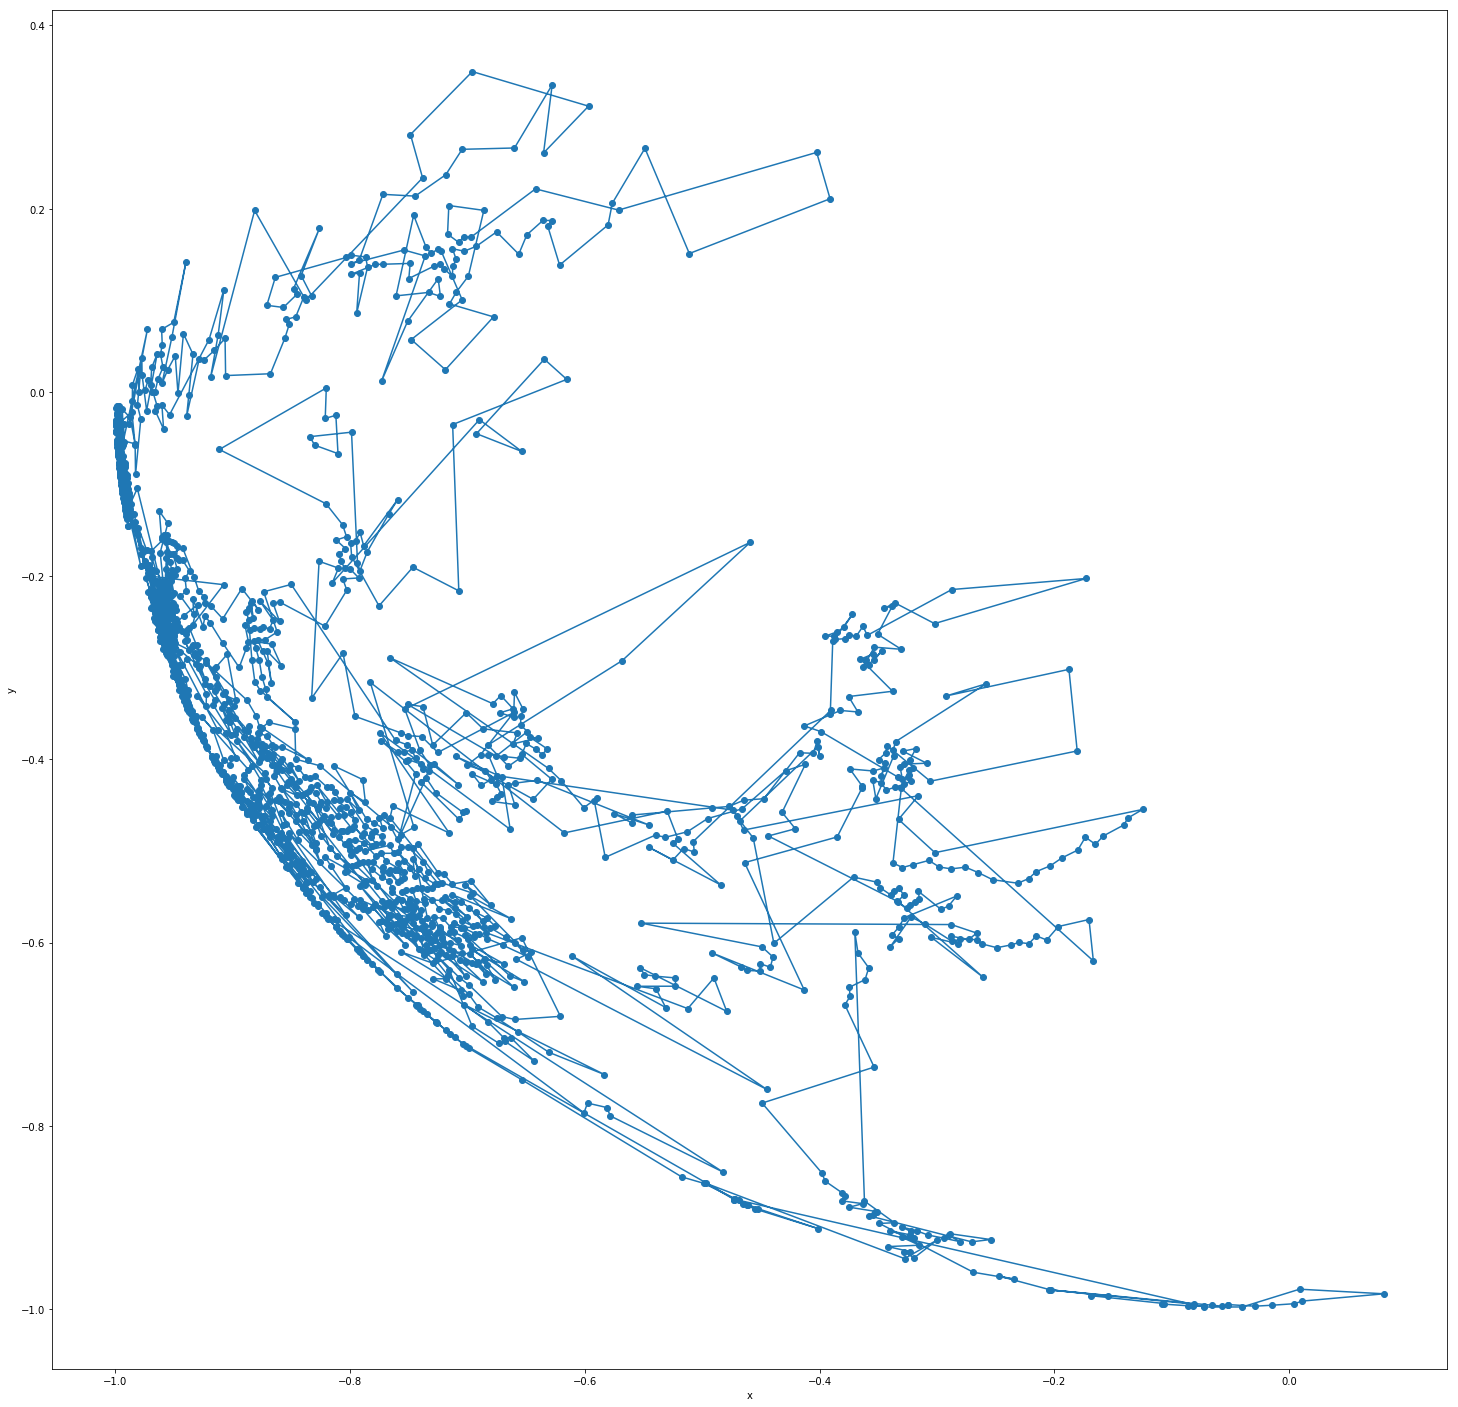

In [16]:
plt.figure(figsize=(25, 25))
plt.plot(x_, y_, 'o-')
plt.ylabel("y")
plt.xlabel("x")
plt.title("")
plt.show()

- **Question 11:** Plot the road mesh that you obtain and explain the result. Create a graph GΔ whose nodes are different locations and whose edges are produced by triangulation. 

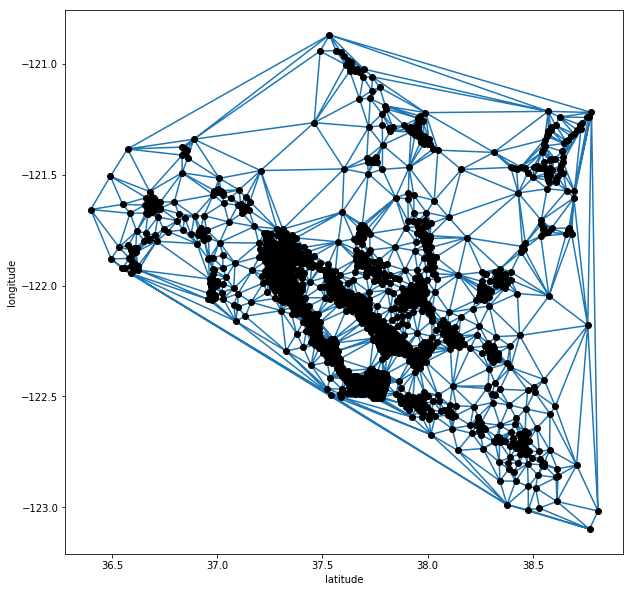

In [17]:
tri = Delaunay(coor_lonlat)
# tri.simplices
plt.figure(figsize=(10, 10))
plt.triplot(coor_lonlat[:,1], coor_lonlat[:,0], tri.simplices.copy())
plt.plot(coor_lonlat[:,1], coor_lonlat[:,0], 'ko')
plt.ylabel("longitude")
plt.xlabel("latitude")
plt.show()

In [18]:
with open('edge_list_p3.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for tris in tri.simplices:
        a = ids[tris[0]]
        b = ids[tris[1]]
        c = ids[tris[2]]
        spamwriter.writerow([a, b])
        spamwriter.writerow([a, c])
        spamwriter.writerow([b, c])

- **Get weight matrix from edge list and save it to csv file**

In [19]:
weight_dict_ = {}
for line in open("edge_list_p3.csv"):
    items = line.split(',')
    k = str(items[0]) + '&' + str(items[1])
    weight_dict_[k] = items[2]
    
matrix_ = np.zeros([len(ids), len(ids)])
i = 0
for sourceid in ids:
    j = 0
    for dstid in ids:
        k = str(sourceid) + '&' + str(dstid)
        if k in weight_dict_.keys():
            w = weight_dict_[k]
            matrix_[i][j] = w
        j += 1
    i += 1

In [20]:
df = pd.DataFrame(matrix_, index=ids, columns=ids)
df.to_csv("weight_mat_Q11.csv", index=True, header=True, sep=',')